In [2]:
import speedyfit
import pickle
import matplotlib.pyplot as pl
import os
import numpy as np
import pandas as pd


import matplotlib.cm as cm
import matplotlib.patches as patches
import matplotlib.ticker as ticker

from scipy.stats import gaussian_kde

overleaf_path = '/Users/daniel/Dropbox (Sydney Uni)/Apps/Overleaf/adra/figs/'



In [3]:
from speedyfit import speedyfit

In [4]:
# os.system("speedyfit fit alf\ Dra_setup_kurucz.yaml")

In [5]:
with open('res.pickle', 'rb') as handle:
    setup, results, samples, constraints, gridnames, obs, obs_err, photbands = pickle.load(handle)

In [6]:
samples

rec.array([(10735.29503121, 3.51965118, 4.70561621, 1.23058911e-03, 2.67040291, 79.04248284, 263.357879  , 8.13171262e-20, 543.08638073),
           (10862.10329927, 3.63895599, 4.57204137, 1.30765563e-03, 3.31794288, 77.55737898, 260.49938675, 8.44611366e-20, 540.0158015 ),
           (10826.45960766, 3.44394606, 4.55296554, 1.57052033e-03, 2.10003916, 77.05591848, 254.99453396, 8.55640172e-20, 541.7929699 ),
           ...,
           (10885.47705712, 3.81166942, 4.54773168, 5.40497840e-05, 4.88598013, 77.327914  , 259.93451248, 8.49631449e-20, 538.9345654 ),
           (10742.08885175, 3.47918873, 4.4813833 , 5.25326046e-04, 2.20650806, 75.38462894, 239.47378374, 8.94000097e-20, 542.82985664),
           (10790.21340996, 3.59514502, 4.66572677, 6.00357857e-04, 3.12374976, 78.75338312, 264.21434165, 8.19152442e-20, 538.07327069)],
          dtype=[('teff', '<f8'), ('logg', '<f8'), ('rad', '<f8'), ('ebv', '<f8'), ('mass', '<f8'), ('d', '<f8'), ('L', '<f8'), ('scale', '<f8'), ('chi2', 

In [7]:
# Print results:
param = 'mass'
samp = (np.percentile(samples[param], [16, 50, 84]))
q = np.diff(samp)
print(" = {0:.2f}_{{-{1:.2f}}}^{{{2:.2f}}}".format(samp[1], q[0], q[1]))

 = 2.92_{-0.74}^{1.33}


In [8]:
from speedyfit import model, filters, reddening

In [9]:
# This function is taken from speedyfit, adapted to make consistent plots with the paper :)

In [10]:
pl.style.use('science')

In [28]:
msize = 4
def plot_fit(obs, obs_err, photbands, pars={}, constraints={}, grids=[], gridnames=[], result='best', plot_components=True, plot_colors=False, plot_constraints=False):
    fig, axes = pl.subplots(2,1, figsize=[3.333333333333333, 3.060113295832983], gridspec_kw={'height_ratios': [0.6, 0.4]})
    pars = pars.copy()

    # use model from 'best' results or 'pc' results
    resi = 0 if result == 'best' else 1

    colors = np.array([filters.is_color(p) for p in photbands])
    psystems = np.array([p.split('.')[0] for p in photbands])
    waves = np.array([filters.eff_wave(p) for p in photbands[~colors]])

    #-- def system colors
    all_systems = set(psystems)
    colorcycle = cm.Set1(np.linspace(0, 1, len(all_systems)))
    system_colors = {}
    for p, c in zip(all_systems, colorcycle):
        system_colors[p] = c

    abs_xlim = (0.9 * np.min(waves), 1.1 * np.max(waves) )

    if not len(list(pars.keys())) == 0:
        ipars = pars.copy()
        for key, value in list(pars.items()):
            ipars[key] = [value[resi]]
            pars[key] = value[resi]
        _ = ipars.pop('d')
        _ = pars.pop('d')

        syn, Labs = model.get_itable(grid=grids, photbands=photbands, **ipars)
        syn = syn[:,0]

        scale = pars['scale']

    # plot the fit of the absolute data
    #====================================
    ax1 = axes[0]
    
    markers = ['o', 'v', 's', 'X']
    
     #-- synthetic model
    ebv = pars['ebv']
    wave, flux = model.get_table(grid=gridnames, **pars)
    flux = reddening.redden(flux, wave=wave, ebv=ebv, rtype='flux', law='fitzpatrick2004')
    ax1.plot(wave, scale*flux, '-k')

    wave, flux, error, band = [], [], [], []
    for system, marker in zip(all_systems, markers):
        s = np.where((psystems == system) & (~colors))
        if len(obs[s]) == 0: continue

        w = np.array([filters.eff_wave(p) for p in photbands[s]])
        ax1.errorbar(w, obs[s], yerr=obs_err[s], ls='', marker=marker, markersize=msize,
#                   color=system_colors[system], 
                     label=system)

        wave.extend(w)
        flux.extend(obs[s])
        error.extend(obs_err[s])
        band.extend([system for i in w])


    ax1.set_xlim(abs_xlim)
    ax1.set_ylim([0.5*np.min(obs[~colors]), 1.6*np.max(obs[~colors])])
    ax1.legend(loc='best', fontsize=6,#prop={'size': 9}, 
      numpoints=1)
    ax1.set_xscale("log",)
    ax1.set_yscale("log",)
    ax1.set_xticks([])
#     ax1.tick_params(labelsize=8.)

    ax1.set_ylabel('Absolute Flux')

    #-- add band names to top of axis
    ax2 = ax1.twiny()
    ax2.set_xscale("log", )
    ax2.set_xlim(abs_xlim)
    waves = np.array([filters.eff_wave(p) for p in photbands[~colors]])
    bandnames = np.array([b.split('.')[-1] for b in photbands[~colors]])
    ax2.set_xticks(waves)
    ax2.set_xticklabels(bandnames, fontsize=7)
    ax2.xaxis.tick_top()
    pl.minorticks_off()
#     ax2.tick_params(labelsize=8.)



#     # plot O-C of the absolute measurements
#     #====================================\
    ax = axes[1]

    for system, marker in zip(all_systems, markers):
        s = np.where((psystems == system) & (~colors))
        if len(obs[s]) == 0: continue

        w = np.array([filters.eff_wave(p) for p in photbands[s]])
        y = ((obs - syn*scale) / obs)[s]
        yerr = (obs_err / obs)[s]

        y = 2.5*np.log10(syn[s]*scale / obs[s])
        yerr = 2.5 / np.log(10.0) * obs_err[s] / obs[s]

        ax.errorbar(w, -y , yerr=yerr, ls='', marker=marker, markersize=msize, 
#                     color=system_colors[system]
                   )

    # pl.figtext(0.96, 0.96, '$\chi^2$ = {:0.2f}'.format(pars['chi2']), ha='right')

    ax.axhline(y=0, color='k', ls='--')

    ax.set_xlim(abs_xlim)
    ax.set_xscale('log')

    ax.set_ylabel('Residuals [mag]')
    ax.set_xlabel('Wavelength [$\AA$]')
    
    pl.subplots_adjust(hspace=0.05)

/Users/daniel/speedyfit/speedyfit/interpol.py:79: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pixelgrid[indices] = grid_data.T


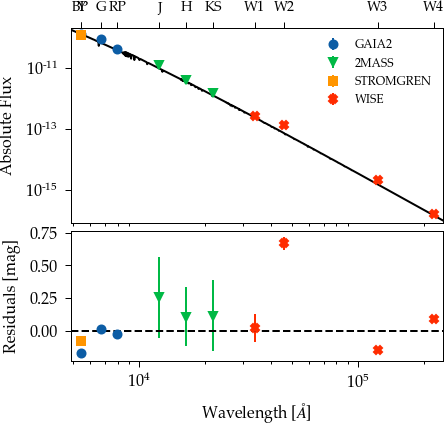

In [29]:
# res = setup[pindex].get('result', 'best')
plot_fit(obs, obs_err, photbands, pars=results, constraints=constraints,
                 grids = setup['grids'], gridnames=gridnames, )

pl.savefig(overleaf_path + 'SED_fit.pdf', dpi=300)

In [116]:
# def wavelength_to_rgb(wavelength, gamma=0.8):

#     '''This converts a given wavelength of light to an 
#     approximate RGB color value. The wavelength must be given
#     in nanometers in the range from 380 nm through 750 nm
#     (789 THz through 400 THz).

#     Based on code by Dan Bruton
#     http://www.physics.sfasu.edu/astro/color/spectra.html
#     '''

#     wavelength = float(wavelength)
#     if wavelength >= 380 and wavelength <= 440:
#         attenuation = 0.3 + 0.7 * (wavelength - 380) / (440 - 380)
#         R = ((-(wavelength - 440) / (440 - 380)) * attenuation) ** gamma
#         G = 0.0
#         B = (1.0 * attenuation) ** gamma
#     elif wavelength >= 440 and wavelength <= 490:
#         R = 0.0
#         G = ((wavelength - 440) / (490 - 440)) ** gamma
#         B = 1.0
#     elif wavelength >= 490 and wavelength <= 510:
#         R = 0.0
#         G = 1.0
#         B = (-(wavelength - 510) / (510 - 490)) ** gamma
#     elif wavelength >= 510 and wavelength <= 580:
#         R = ((wavelength - 510) / (580 - 510)) ** gamma
#         G = 1.0
#         B = 0.0
#     elif wavelength >= 580 and wavelength <= 645:
#         R = 1.0
#         G = (-(wavelength - 645) / (645 - 580)) ** gamma
#         B = 0.0
#     elif wavelength >= 645 and wavelength <= 750:
#         attenuation = 0.3 + 0.7 * (750 - wavelength) / (750 - 645)
#         R = (1.0 * attenuation) ** gamma
#         G = 0.0
#         B = 0.0
#     else:
#         R = 0.0
#         G = 0.0
#         B = 0.0
#     R *= 255
#     G *= 255
#     B *= 255
#     return (int(R), int(G), int(B))


## Make photometry table

In [30]:
obs = pd.read_csv('observations.txt', delim_whitespace=True)

In [32]:
for index, row in obs.iterrows():
    print(f"{row['band']} & {row['wave']:.2f} & {row['flux']:.2E} & {row['error']:2E}")

WISE & 33791.90 & 2.68E-13 & 2.691451E-14
WISE & 46293.00 & 1.41E-13 & 6.773235E-15
WISE & 123337.00 & 2.09E-15 & 2.693549E-17
WISE & 222532.00 & 1.67E-16 & 2.925200E-18
GAIA2 & 6710.93 & 9.50E-11 & 2.273937E-13
GAIA2 & 5437.48 & 1.36E-10 & 1.747251E-12
GAIA2 & 7979.59 & 4.54E-11 & 1.504805E-13
STROMGREN & 5477.32 & 1.26E-10 & 2.314065E-12
2MASS & 12412.10 & 1.29E-11 & 3.637680E-12
2MASS & 16497.10 & 4.03E-12 & 8.318663E-13
2MASS & 21909.20 & 1.50E-12 & 3.754546E-13
